### Preliminars

##### Imports

In [17]:
import scipy as sci
from scipy import stats
from scipy.special import expit
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools as iter
%matplotlib widget

cluster = True
np.random.seed(42)


##### Visualization

In [18]:
def set_axis_labels(ax, x, y, z=None):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    if z != None:
        ax.set_zlabel(z)


def plot_cluster(X, U, Ud=None, C=None,
                 title="Clusters",
                 axes_names=["$X_0$", "$X_1$", "$Y_0$"],
                 cluster_names=None):
    C_N= U.shape[0]
    compare = Ud is not None
    error = 0

    cmap = plt.get_cmap("viridis")
    cnorm = mpl.colors.Normalize(vmin=0, vmax=C_N-1)
    plt.figure()
    ax = plt.axes(projection="3d", title=title)
    
    U = np.argmax(U, axis=0)
    Ud = np.argmax(Ud, axis=0) if compare else U
    if cluster_names is None:
        cluster_names = [f"C{c}" for c in range(C_N)]
    for c in range(C_N):
        x = U == c
        xT = x & (Ud == c)
        xF = x & (Ud != c)
        c_name = cluster_names[c] + f": {np.sum(xT)}"
        if compare:
            e_c = np.sum(xF)
            c_name += f" - {e_c}"
            error += e_c
        ax.scatter(*X[:3, xT], color=cmap(cnorm(c)), label=c_name)
        ax.scatter(*X[:3, xF], color=cmap(cnorm(c)), marker="x")
    
    set_axis_labels(ax, *axes_names)
    if compare:
        ax.scatter([], [], [], color='k', marker="x", label=f"Errors: {error}")
    ax.legend()

##### Misc

In [19]:
def normalize(points):
    min = points.min(axis=1, keepdims=True)
    scale = points.max(axis=1, keepdims=True) - min
    def denormalize(points): return points * scale + min
    return (points - min) / scale, denormalize

def name_to_int(data):
    names = data.unique()
    name_map = dict(map(reversed, enumerate(names)))
    return data.apply(lambda x: name_map[x]), names

def vectorize(data):
    I = np.identity(np.max(data) + 1)
    return I[:, data]



### Definitions

##### Norms

In [20]:
norm_names = [
    "Euclidean2",
    "Manhattan",
    "Infinity",
    "Mahalanobis2"
]

norm = dict(zip(norm_names, [
    lambda x: np.sum(x**2, axis=0, keepdims=True),
    lambda x: np.sum(np.abs(x), axis=0, keepdims=True),
    lambda x: np.max(np.abs(x), axis=0, keepdims=True),
    lambda S: lambda x: np.concatenate(
        [c[None, :] @ inv(S) @ c[:, None] for c in x.T])
]))

def dist_matrix(X, Y, norm=norm["Euclidean2"]):
    D = np.zeros((X.shape[1], Y.shape[1]))
    for x, y in iter.product(range(X.shape[1]), range(Y.shape[1])):
        D[x, y] = norm(X[:, x] - Y[:, y])
    return D


def compare_cluster(U, Ud):
    D = dist_matrix(U.T, Ud.T, norm["Manhattan"])
    return U[np.argmin(D, axis=0), :]


##### PDFs

In [21]:
pdf_names = ["Uniform", "Triangular", "Normal"]


def pdf(pdf, x, N):
    return pd.Series(dict(zip(pdf_names, [
        sci.stats.uniform.pdf(x, 0, N),
        sci.stats.triang.pdf(x, 0.5, -1, N+1),
        sci.stats.norm.pdf(x, N//2, N//6)])
    )[pdf], index=x)

##### Learner measures

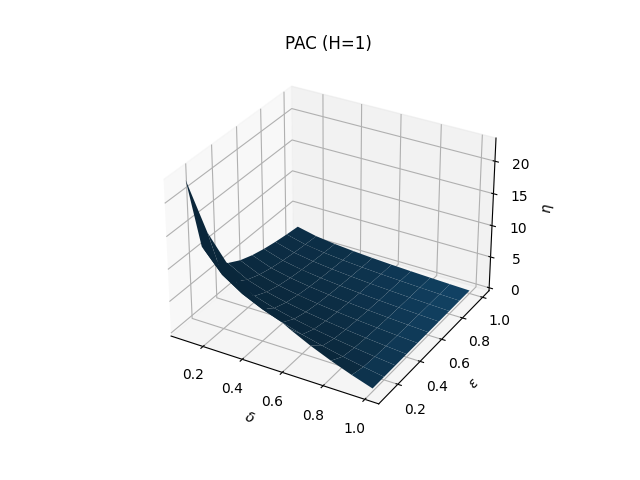

In [22]:
def confusion_supervised(U, Ud):
    C_N, X_N = U.shape
    CM = np.zeros((C_N, C_N))
    U, Ud = np.argmax(U, axis=0), np.argmax(Ud, axis=0)

    for x in range(X_N):
        CM[U[x], Ud[x]] += 1
    return CM

# lower bound to sample size
def PAC_eta(H_norm, delta, epsilon):
    return (np.log(H_norm) - np.log(delta))/epsilon

# lower bound to generalization error
def PAC_delta(H_norm, epsilon, eta):
    return H_norm/np.exp(eta*epsilon)

H = 1
plt.figure()
X = Y = np.linspace(0.1, 1, 10)
X, Y = np.meshgrid(X, Y)
ax = plt.axes(projection='3d', title=f'PAC (H={H})')
ax.plot_surface(X, Y, PAC_eta(H, X, Y))
set_axis_labels(ax, '$\\delta$', '$\\varepsilon$', '$\\eta$')

### Data Retrieval

##### Read Data

In [23]:
if cluster:
    file = 'iris.csv'
    index_col, header = 0, 0
else:
    file = 'examen.csv'
    index_col, header = None, None
data = pd.read_csv(file, index_col=index_col, header=header).reset_index(drop=True)
N_S = len(data.index)
indices = data.index
axes_names = data.columns.to_list()

X_S, Y_S = data.iloc[:, :-1], data.iloc[:, -1]
X_S, denormalize_X = normalize(X_S.to_numpy().T)

if cluster:
    Y_S, cluster_names = name_to_int(Y_S)
    Y_S = vectorize(Y_S.to_list())
else:
    Y_S, denormalize_Y = normalize(Y_S.to_numpy().T)


# Sampling

##### Distribution Comparison (PDF)

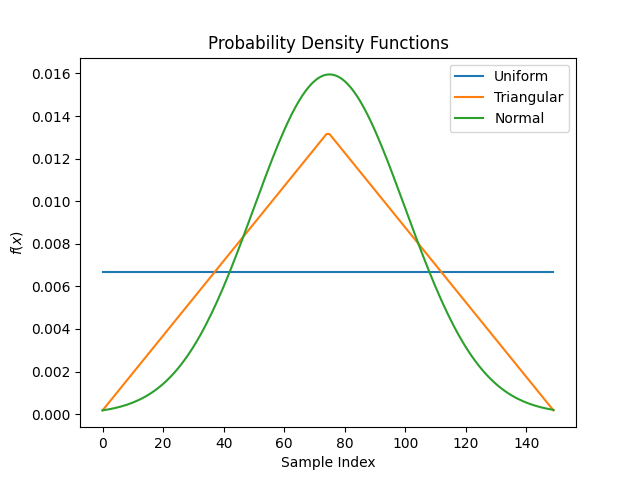

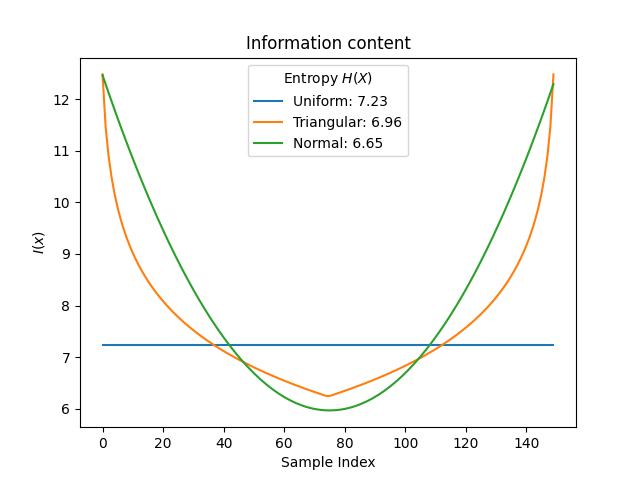

In [24]:
plt.figure()
ax = plt.axes(title="Probability Density Functions")
for name in pdf_names:
    F = pdf(name, indices, N_S)
    ax.plot(indices, F, label=name)
plt.legend()
set_axis_labels(ax, "Sample Index", "$f(x)$")

plt.figure()
ax = plt.axes(title="Information content")
for name in pdf_names:
    F = pdf(name, indices, N_S)
    I = np.log2(1/F)
    H = np.sum(-F*np.log2(F))
    plt.plot(indices, I, label=f"{name}: {H:.2f}")
plt.legend(title="Entropy $H(X)$")
set_axis_labels(ax, "Sample Index", "$I(x)$")


##### Distribution Comparison (Sample)

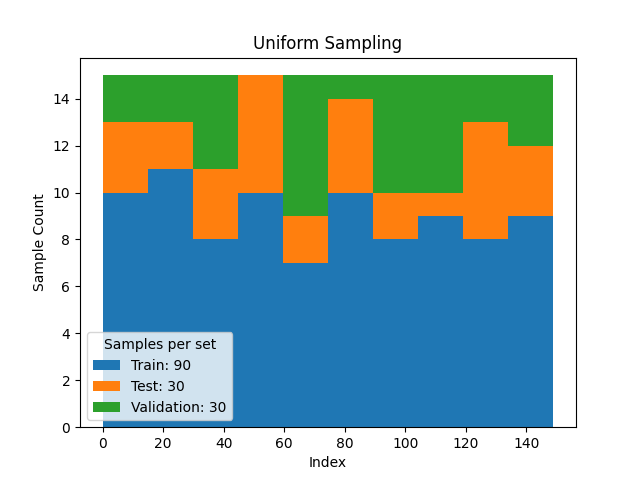

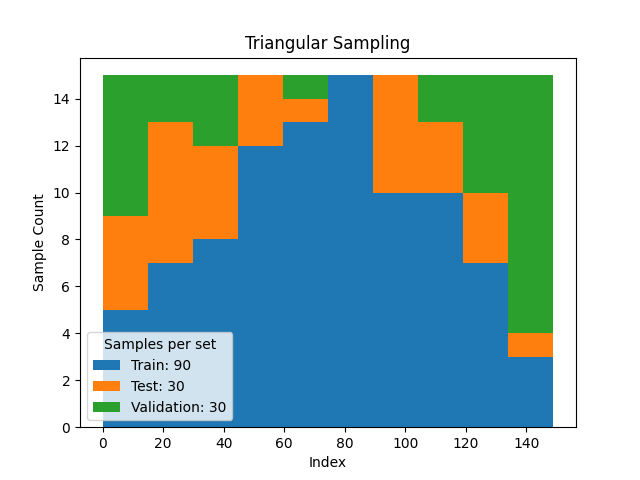

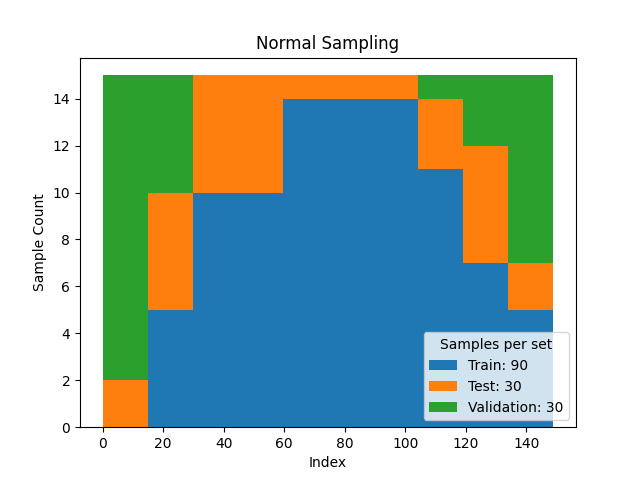

In [25]:
sets = {"Train": int(0.6*N_S),
        "Test": int(0.2*N_S),
        "Validation": int(0.2*N_S)}

sets_S = sets.copy()

for name in pdf_names:
    weights = pdf(name, indices, N_S)
    sets_curr = sets.copy()
    plt.figure()
    ax = plt.axes(title=f"{name} Sampling")
    
    for k, v in sets_curr.items():
        sample = np.random.choice(weights.index, size=v, p=weights/weights.sum(), replace=False)
        sets_curr[k] = sample
        if name == "Uniform":
            sets_S[k] = (X_S[:, sample], Y_S[:, sample])
        weights = weights.drop(sample)

    ax.hist(sets_curr.values(), stacked=True, bins=10,
        label=[f"{k}: {len(v)}" for k, v in sets_curr.items()]) 
    set_axis_labels(ax, 'Index', 'Sample Count')   
    plt.legend(title="Samples per set")

# Supervised Learning

### Neural Network

##### Definition

In [26]:
def softmax(x): return np.exp(x) / np.sum(np.exp(x), axis=0)
def dsoftmax(x): return softmax(x) * (np.eye(x.shape[0]) - softmax(x).T)
def sigmoid(x): return expit(x)
def dsigmoid(x): return sigmoid(x) * (1 - sigmoid(x))


def feedforward(X, phi, dphi, W, B=None, cluster=False, Yd = None, full=False):
    k = len(W) - 1
    V = [None] * (k+1)
    Y = [None] * (k+1)
    Y[0] = X
    for l in range(1, k+1):
        V[l] = W[l] @ Y[l-1]
        if B != None:
            V[l] += B[l]
        Y[l] = phi(V[l])
    if cluster:
        Y[k] = softmax(V[k])
    if Yd is None:
        E = 0
    else:
        dE = Y[k] - Yd
        E = np.average(norm["Euclidean2"](Y[k] - Yd))/2
    if full:
        return Y, V, E, dE
    else:
        return Y[k], E
    

def update(X, Yd, phi, dphi, W, B=None, cluster=False, eta=1):
    p = X.shape[1]
    k = len(W) - 1

    # feedforward
    Y, V, E, dE = feedforward(X,phi, dphi, W, B, cluster, Yd, full=True)
    # backpropagation
    delta = [None] * (k+1)
    if cluster:
        delta[k] = np.concatenate([dsoftmax(V[k][:, [c]]) @ dE[:, [c]]
            for c in range(p)], axis=1)
    else:
        delta[k] = dphi(V[k]) * dE

    for l in reversed(range(1, k)):
        delta[l] = (W[l+1].T @ delta[l+1]) * dphi(V[l])

    # update

    for l in range(1, k+1):
        W[l] -= eta * (delta[l] @ Y[l-1].T) / p
        if B != None:
            B[l] -= eta * (delta[l] @ np.ones((p, 1))) / p
    return delta, E, W, B


##### Run

In [27]:
X, Yd = sets_S["Train"]
X_test, Yd_test = sets_S["Test"]
neurons = [X.shape[0], 2, 2, Yd.shape[0]]
k = len(neurons) - 1
epochs = 1000

W = [None] * (k+1)
B = [None] * (k+1)
for l in range(1, k+1):
    W[l] = np.random.randn(neurons[l], neurons[l-1])
    B[l] = np.random.randn(neurons[l])[:, None]

delta = []
E = {"Train": [],
    "Test": [],
    "Validation": []}
Y_test = []
epochs = 0
delta_curr = np.inf
while epochs < 1000:
    Y_test_curr, E_test_curr = feedforward(
        X_test, sigmoid, dsigmoid, W, B, cluster, Yd_test)
    Y_test.append(Y_test_curr)
    E["Test"].append(E_test_curr)
    
    delta_curr, E_train, W, B = update(X, Yd, sigmoid, dsigmoid, W, B, cluster, 1)
    delta_curr = [np.mean(norm["Euclidean2"](delta_curr[l]))
                     for l in range(1, k+1)]
    delta.append(delta_curr)
    E["Train"].append(E_train)
    epochs += 1


##### Graphs

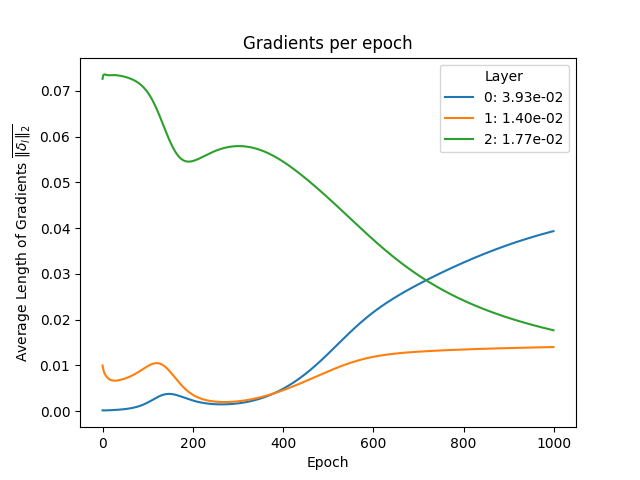

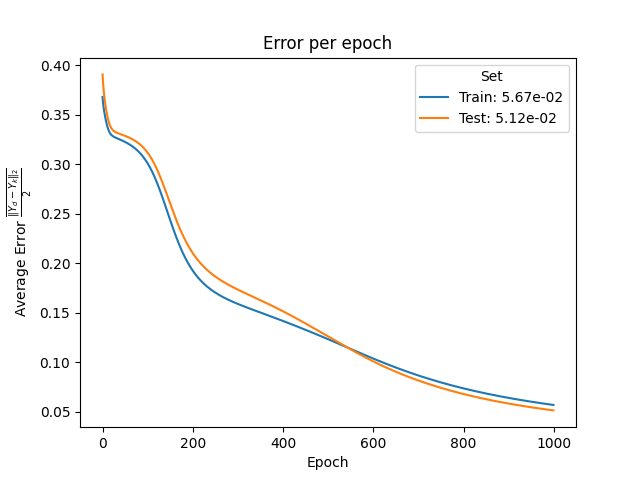

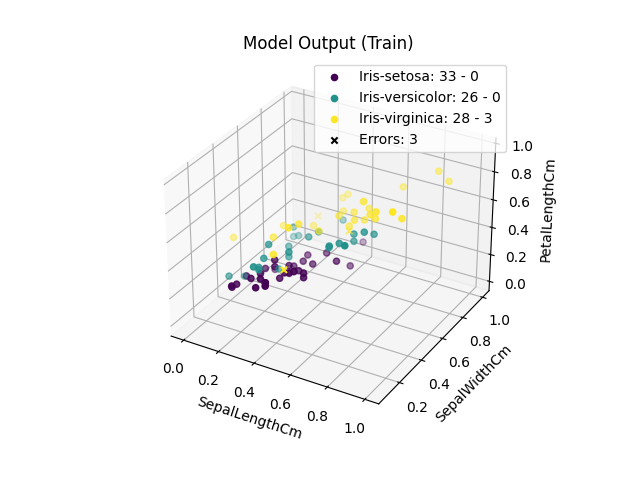

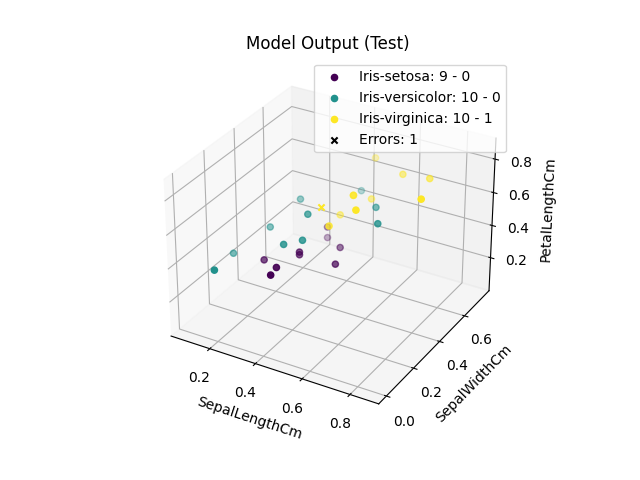

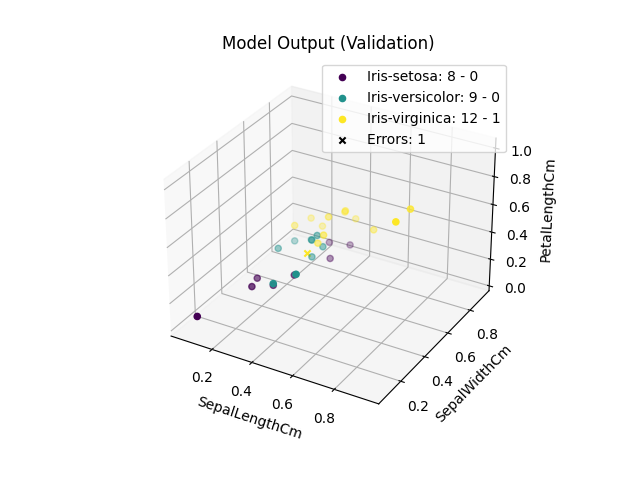

In [28]:
plt.figure()
ax = plt.axes(title=f"Gradients per epoch")
gradients = [f"{l}: {d:.2e}" for l, d in enumerate(delta[-1])]
ax.plot(range(epochs), delta, label=gradients)
ax.legend(title="Layer")
set_axis_labels(ax, "Epoch", 
    "Average Length of Gradients $\\overline{\\Vert\\delta_l\\Vert_2}$")

plt.figure()
ax = plt.axes(title=f"Error per epoch")
ax.plot(range(epochs), E["Train"], label=f"Train: {E['Train'][-1]:.2e}")
ax.plot(range(epochs), E["Test"], label=f"Test: {E['Test'][-1]:.2e}")
plt.legend(title="Set")
set_axis_labels(ax, "Epoch",
    "Average Error $\\frac{\\overline{\\Vert Y_d - Y_k\\Vert_2}}{2}$")

if cluster:
    for name, XY_S in sets_S.items():
        U, _ = feedforward(XY_S[0], sigmoid, dsigmoid, W, B, cluster=True)
        plot_cluster(XY_S[0], U, Ud=XY_S[1],
            title=f"Model Output ({name})",
            cluster_names=cluster_names[:3], axes_names=axes_names[:3])
else:
    plot_N = 11
    ticks = np.linspace(1, len(Y_test), plot_N, dtype=int)
    plt.figure()
    ax = plt.axes(projection="3d", title=f"Output (Test)")
    ax.scatter(*X_test[:2, :], Yd_test, label="Reference", color='darkgreen')
    plt.legend()
    cmap = plt.get_cmap("inferno_r")
    cnorm = mpl.colors.Normalize(vmin=np.min(ticks), vmax=np.max(ticks))
    for c in ticks-1:
        ax.scatter(*X_test[:2, :], Y_test[c][0], color = cmap(cnorm(c)), alpha=0.5)
  
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=cnorm)
    cbar = plt.colorbar(sm, ticks=ticks, ax=ax,
                        location="bottom", label="Epoch")
    set_axis_labels(ax, "$X_0$", "$X_1$", "$Y_0$")

# Unsupervised Learning

### K-means

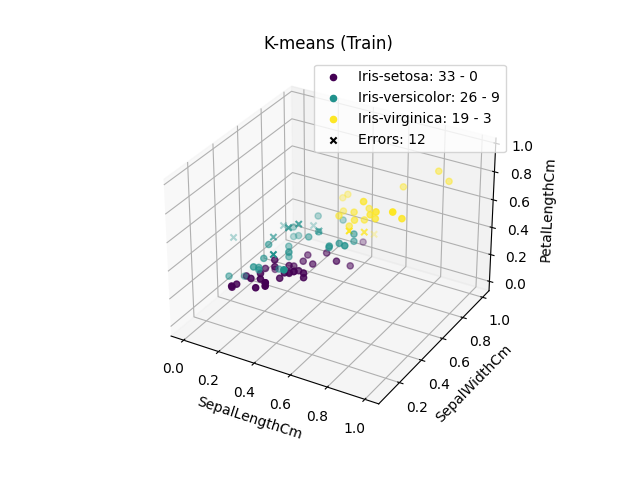

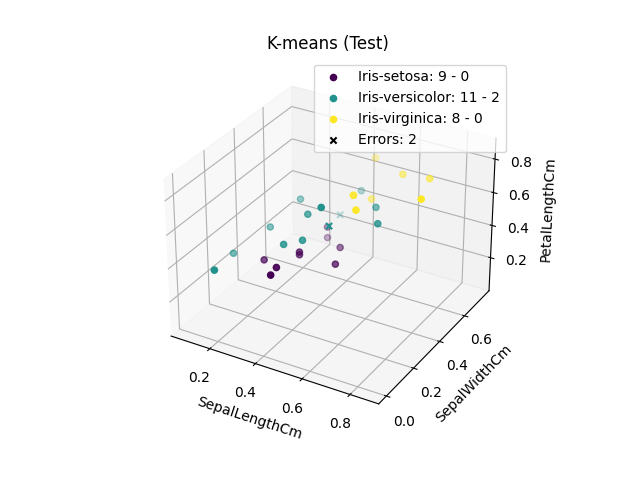

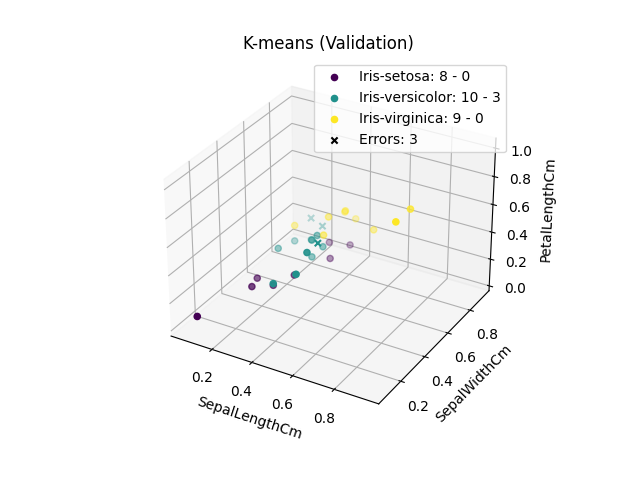

In [29]:
def cost(X, U, C, norm=norm["Euclidean2"]):
    return np.sum(norm(X - C[:, np.argmax(U, axis=0)]))


def update_clusters(X, C, norm=norm["Euclidean2"]):
    U = np.zeros((C.shape[1], X.shape[1]), dtype=int)
    D = dist_matrix(C, X, norm)
    I = np.identity(C.shape[1])
    for x, c in enumerate(np.argmin(D, axis=0)):
        U[:, x] = I[:, c]
    return U

def update_centers(X, U):
    C = np.zeros((X.shape[0], U.shape[0]))
    for c, u in enumerate(U):
        C[:, c] = np.average(X[:, u == 1], axis=1)
    return C


def k_means(k, X, epsilon, norm=norm["Euclidean2"]):
    C = X[:, np.random.randint(0, X.shape[1], size=k)]
    J, J_new = np.inf, 0
    while np.abs(J - J_new) > epsilon:
        J = J_new
        U = update_clusters(X, C)
        C = update_centers(X, U)
        J_new = cost(X, U, C, norm)
    return update_clusters(X, C), C

U, C = k_means(3, X, 0.002)
for name, XY_S in sets_S.items():
    U = update_clusters(XY_S[0], C)
    plot_cluster(XY_S[0], compare_cluster(U, XY_S[1]), Ud=XY_S[1], C=C,
        title=f"K-means ({name})", 
        cluster_names=cluster_names[:3], axes_names=axes_names[:3])


### Fuzzy C-means

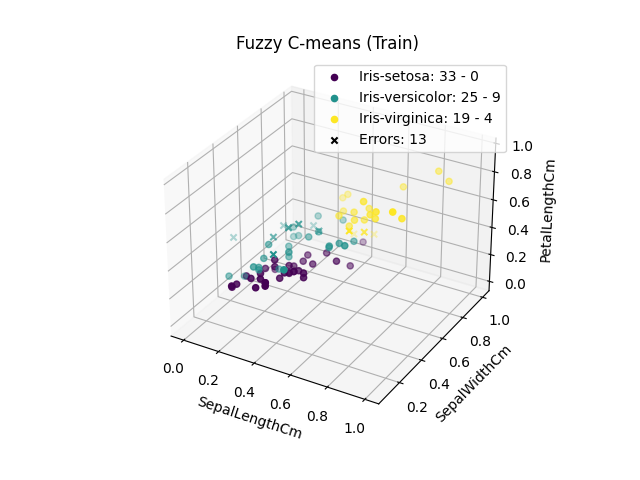

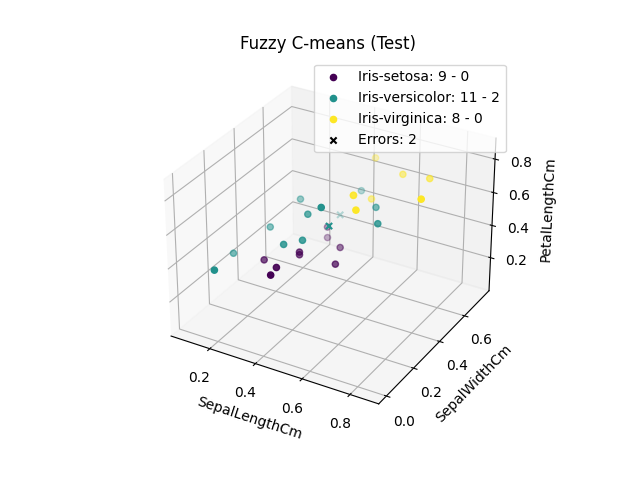

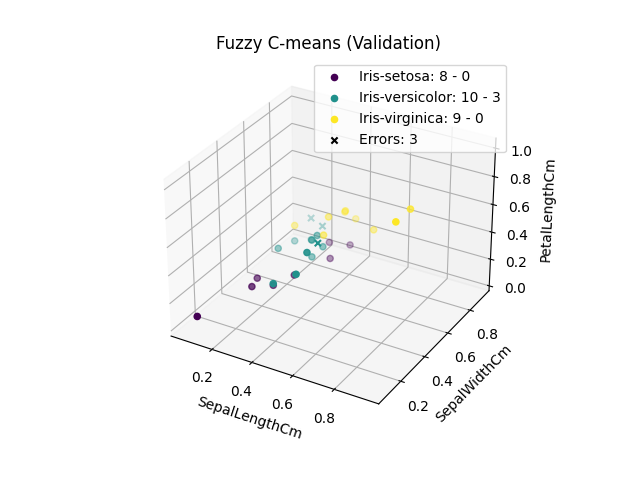

In [30]:
def cost_fuzzy(X, U, C, m, norm=norm["Euclidean2"]):
    D = dist_matrix(C, X, norm)
    return np.sum((U[:, :]**m) * D[:, :])

def update_centers_fuzzy(X, U, m):
    C = np.zeros((X.shape[0], U.shape[0]))
    Um = U**m
    for c in range(C.shape[1]):
        C[:, c] = np.sum(Um[c, :] * X[:, :], axis=1) / np.sum(Um[c, :])
    return C


def update_clusters_fuzzy(X, C, m, norm=norm["Euclidean2"]):
    D = dist_matrix(C, X, norm)**(1/(m-1))
    U = np.zeros((C.shape[1], X.shape[1]))
    for x in range(X.shape[1]):
        U[:, x] = 1/(D[:, x] * np.sum(1/D[:, x]))
    U[D==0] = 1
    return U

def fuzzy_c_means(c, X, m, epsilon):
    U = np.random.random((c, X.shape[1]))
    U /= np.sum(U, axis=0)
    C = update_centers_fuzzy(X, U, m)
    J, J_new = np.inf, 0
    while np.abs(J - J_new) > epsilon:
        J = J_new
        C = update_centers_fuzzy(X, U, m)
        U = update_clusters_fuzzy(X, C, m)
        J_new = cost_fuzzy(X, U, C, m)
    return U, C

m = 2
U, C = fuzzy_c_means(3, X, m, 0.002)
for name, XY_S in sets_S.items():
    U = update_clusters_fuzzy(XY_S[0], C, m)
    plot_cluster(XY_S[0], compare_cluster(U, XY_S[1]), Ud=XY_S[1], C=C,
                 title=f"Fuzzy C-means ({name})",
                 cluster_names=cluster_names[:3], axes_names=axes_names[:3])


### Mountain Clustering

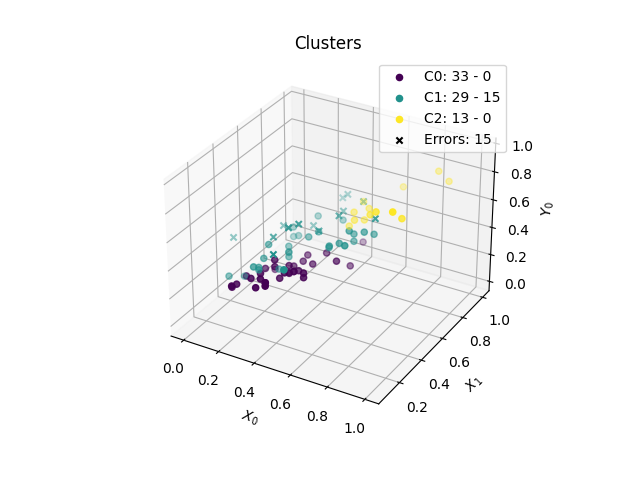

In [31]:
def mountain(X, n, sigma, beta, epsilon=0, norm=norm["Euclidean2"]):
    def f(v, a): return np.exp(-norm(v)/(2 * a**2))
    def col(v): return np.array(v)[:, None]
    m = iter.product(*[np.linspace(0, 1, n)
               for _ in range(X.shape[0])])
    m = {v: np.sum(f(X - col(v), sigma)) for v in m}
    mc, mc_new = 0, np.inf
    C = []
    while True:
        c = max(m, key=m.get)
        if m[c] <= epsilon:
            break
        mc = m[c]
        C.append(col(c))
        m = {v: np.max(m[v] - m[c] * f(col(c) - col(v), beta), 0)
            for v in m}
    return np.concatenate(C, axis=1)

C = mountain(X, 10, 1, 1, 0.5)
U = update_clusters_fuzzy(X, C, 3)
plot_cluster(X, compare_cluster(U, Yd), C=C, Ud=Yd)

C:\Users\Orfy\AppData\Local\Temp\ipykernel_11732\3545949227.py:17: RuntimeWarning: divide by zero encountered in divide
  U[:, x] = 1/(D[:, x] * np.sum(1/D[:, x]))
C:\Users\Orfy\AppData\Local\Temp\ipykernel_11732\3545949227.py:17: RuntimeWarning: invalid value encountered in multiply
  U[:, x] = 1/(D[:, x] * np.sum(1/D[:, x]))


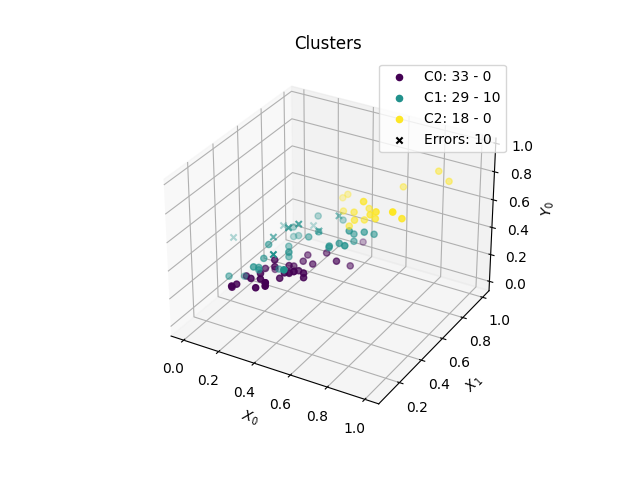

In [32]:
def substractive(X, n, sigma, beta, epsilon=0, norm=norm["Euclidean2"]):
    def f(v, a): return np.exp(-norm(v)/(2 * a**2))
    m = [np.sum(f(X - v[:, None], sigma)) for v in X.T]
    mc, mc_new = 0, np.inf
    C = []
    while True:
        c = np.argmax(m)
        if m[c] <= epsilon:
            break
        mc = m[c]
        C.append(X[:, [c]])
        m = [np.max(m[v] - m[c] * f(X[:,c] - X[:, v], beta), 0)
             for v in range(len(m))]
    return np.concatenate(C, axis=1)


C = substractive(X, 10, 1, 1, 0.05)
U = update_clusters_fuzzy(X, C, 3)
plot_cluster(X, compare_cluster(U, Yd), C=C, Ud=Yd)


### Indexes

##### Internal

In [33]:
# Higher is better
def silhouette(X, U, norm=norm["Euclidean2"]):
    Cn, Xn = U.shape
    U = np.argmax(U, axis=0)
    Un = [np.sum(U == c) for c in range(Cn)]
    D = dist_matrix(X, X, norm)
    a = np.array([[np.sum(D[x, U == c])/(Un[c] - (U[x] == c))
        for x in range(Xn)]
        for c in range(Cn)])
    b = np.array([np.min(a[np.array(range(Cn)) != U[x], x])
        for x in range(Xn)])
    s = np.array([(b[x] - a[U[x], x]) / np.max([a[U[x], x], b[x]])
        for x in range(Xn)])
    sC = [np.mean(s[U == c]) for c in range(Cn)]
    return np.mean(sC)

silhouette(X, U)

0.7314028701663866

##### External

In [42]:
def confusion_unsupervised(U1, U2):
    U1, U2 = np.argmax(U1, axis=0), np.argmax(U2, axis=0)
    CM = np.zeros((2,2))
    for u in range(U1.shape[0]):
        for v in range(u):
            p1 = U1[u] == U1[v]
            p2 = U2[u] == U2[v]
            CM += [[p1 and p2, p1 and not p2], [not p1 and p2, not p1 and not p2]]
    return CM

index_names = ["P", "R", "F", "Mu", "Sigma2", "Phi", "Rand"]
index = dict(zip(index_names,[
    lambda CM: #Precision
        CM[0,0] / (CM[0,0] + CM[1,0]),
    lambda CM: #Recall
        CM[0, 0] / (CM[0, 0] + CM[0, 1]),
    lambda alpha: lambda CM: #F-alpha
        (1 + alpha) * index["P"](CM) * index["R"](CM) /
        (alpha * index["P"](CM) + index["R"](CM)),
    lambda CM: #Mean
        (CM[0,0] + CM[0,1]) / np.sum(CM),
    lambda CM: #Variance
        index["Mu"](CM) - index["Mu"](CM)**2,
    lambda CM: #Phi
        (CM[0,0] * CM[1,1] - CM[0,1] * CM[1,0]) /
        ((CM[0, 0] + CM[0, 1]) * (CM[0, 0] + CM[1, 0])
         * (CM[0, 1] + CM[1, 1]) * (CM[1, 0] + CM[1, 1])),
    lambda CM: #Rand
        (CM[0,0] + CM[1,1])/np.sum(CM)
]))

index["Phi"](confusion_unsupervised(Yd, U))


2.0558479117032579e-07